# Step 3: Clustering

In [1]:
# Retrieve the dataframe using %store
%store -r df

## 2.1 Feature Extraction
Doc2Vec is used to convert the abstracts into vectors.

In [2]:
from gensim.models.doc2vec import Doc2Vec
from sklearn.model_selection import ParameterGrid
from gensim.models.doc2vec import TaggedDocument

# Create TaggedDocument objects using preprocessed tokenized abstracts
tagged_data = [TaggedDocument(words=abstract, tags=[str(i)]) for i, abstract in enumerate(df['abstract'])]

# Define a grid of hyperparameters to explore
param_grid = {
    'alpha': [0.025, 0.05],
    'min_count': [1, 2, 3],
    'window': [3, 5, 7],
    'epochs': [50, 75, 100]
}

best_model = None
best_corpus_count = 0

# Iterate over the parameter grid to find the best combination of hyperparameters
for params in ParameterGrid(param_grid):
    print("Training with parameters:", params)
    
    # Train Doc2Vec model
    model = Doc2Vec(**params)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    
    # Assess model's general performance (use corpus count as a proxy)
    corpus_count = model.corpus_count
    
    # Update best model if necessary
    if corpus_count > best_corpus_count:
        best_corpus_count = corpus_count
        best_model = model

print("Best model:", best_model)

Training with parameters: {'alpha': 0.025, 'epochs': 50, 'min_count': 1, 'window': 3}
Training with parameters: {'alpha': 0.025, 'epochs': 50, 'min_count': 1, 'window': 5}
Training with parameters: {'alpha': 0.025, 'epochs': 50, 'min_count': 1, 'window': 7}
Training with parameters: {'alpha': 0.025, 'epochs': 50, 'min_count': 2, 'window': 3}
Training with parameters: {'alpha': 0.025, 'epochs': 50, 'min_count': 2, 'window': 5}
Training with parameters: {'alpha': 0.025, 'epochs': 50, 'min_count': 2, 'window': 7}
Training with parameters: {'alpha': 0.025, 'epochs': 50, 'min_count': 3, 'window': 3}
Training with parameters: {'alpha': 0.025, 'epochs': 50, 'min_count': 3, 'window': 5}
Training with parameters: {'alpha': 0.025, 'epochs': 50, 'min_count': 3, 'window': 7}
Training with parameters: {'alpha': 0.025, 'epochs': 75, 'min_count': 1, 'window': 3}
Training with parameters: {'alpha': 0.025, 'epochs': 75, 'min_count': 1, 'window': 5}
Training with parameters: {'alpha': 0.025, 'epochs': 7

In [3]:
# Use the best model to infer document vectors
document_vectors = [best_model.infer_vector(tokenized_abstract) for tokenized_abstract in df['abstract']]

## 2.2 Dimensionality Reduction

In [4]:
import numpy as np

print("Mean of document_vectors:", np.mean(document_vectors))
print("Standard Deviation of document_vectors:", np.std(document_vectors))

Mean of document_vectors: 0.03908808
Standard Deviation of document_vectors: 1.0589058


### Further scaling

In [5]:
from sklearn.preprocessing import StandardScaler

# Scale the document vectors
scaler = StandardScaler()
document_vectors = scaler.fit_transform(document_vectors)

### Definition of Number of Components

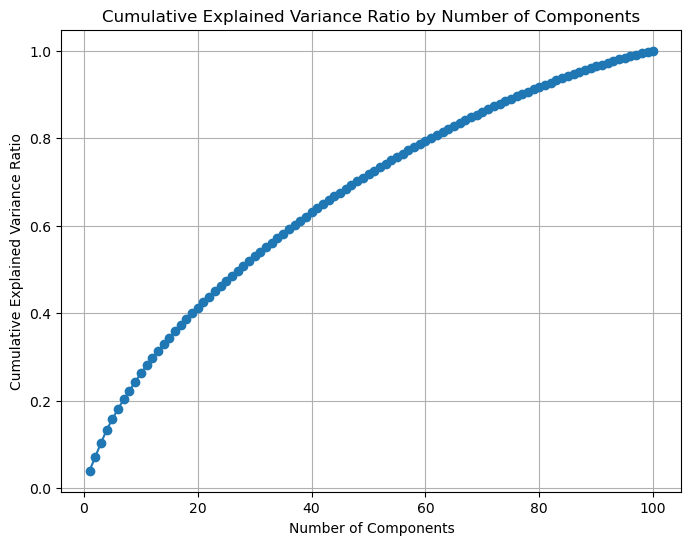

Number of Components Selected: 69


In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Initialize PCA with desired number of components
n_components = 100  
pca = PCA(n_components=n_components)

# Fit PCA to document vectors
pca.fit(document_vectors)

# Transform the document vectors to the lower-dimensional space
document_vectors_pca = pca.transform(document_vectors)

# Visualize the cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.title('Cumulative Explained Variance Ratio by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')

plt.grid(True)
plt.show()

# Determine the number of components to keep for 85% variance explained
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.85) + 1
print("Number of Components Selected:", n_components)

### PCA Visualization

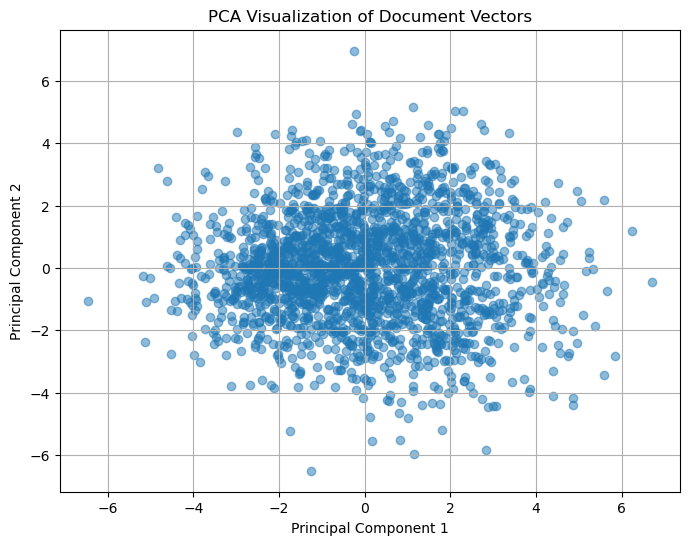

In [7]:
# Initialize PCA with desired number of components
pca = PCA(n_components=n_components)

# Fit PCA to document vectors
pca.fit(document_vectors)

# Transform the document vectors to the lower-dimensional space
document_vectors_pca = pca.transform(document_vectors)

# Visualize the reduced-dimensional data
plt.figure(figsize=(8, 6))
plt.scatter(document_vectors_pca[:, 0], document_vectors_pca[:, 1], alpha=0.5)
plt.title('PCA Visualization of Document Vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

## 2.3 Clustering

### Definition of Number of Clusters
A gap statistic is used to define the optimum number of clusters

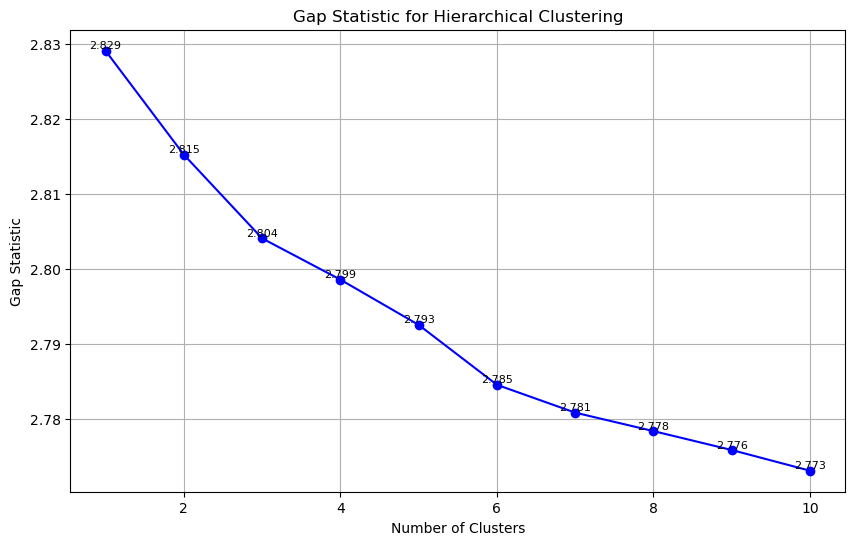

In [8]:
import numpy as np
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

def compute_inertia(X, labels):
    """Compute the within-cluster dispersion (inertia) for a given clustering."""
    inertia = 0
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_indices = np.where(labels == label)[0]
        cluster_points = [X[i] for i in cluster_indices]
        centroid = np.mean(cluster_points, axis=0)
        inertia += np.sum(np.linalg.norm(cluster_points - centroid, axis=1) ** 2)
    return inertia

def gap_statistic(X, max_clusters=10, n_refs=10):
    """Compute the gap statistic for hierarchical clustering."""
    X = np.array(X)  # Convert to NumPy array
    gaps = []
    for k in range(1, max_clusters + 1):
        hierarchical_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward', compute_distances=True)
        hierarchical_clustering.fit(X)
        labels = hierarchical_clustering.labels_
        inertia = compute_inertia(X, labels)
        
        # Compute gap statistic for the current number of clusters
        gap = np.log(inertia)
        
        # Compute reference distribution for the current number of clusters
        ref_gaps = []
        for _ in range(n_refs):
            # Generate random data as reference distribution
            ref_data = np.random.rand(*X.shape)
            ref_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward', compute_distances=True)
            ref_clustering.fit(ref_data)
            ref_labels = ref_clustering.labels_
            ref_inertia = compute_inertia(ref_data, ref_labels)
            ref_gap = np.log(ref_inertia)
            ref_gaps.append(ref_gap)
        
        # Compute gap statistic for the reference distribution
        gap -= np.mean(ref_gaps)
        gap *= np.sqrt(1 + 1/n_refs)
        gaps.append(gap)
    
    return gaps


# Compute the gap statistic
gap_values = gap_statistic(document_vectors_pca)

# Plot the gap statistic values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(gap_values) + 1), gap_values, marker='o', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic for Hierarchical Clustering')

# Annotate points with their values
for i, value in enumerate(gap_values):
    plt.text(i + 1, value, f'{value:.3f}', fontsize=8, ha='center', va='bottom')

plt.grid(True)
plt.show()

### Dendrogram

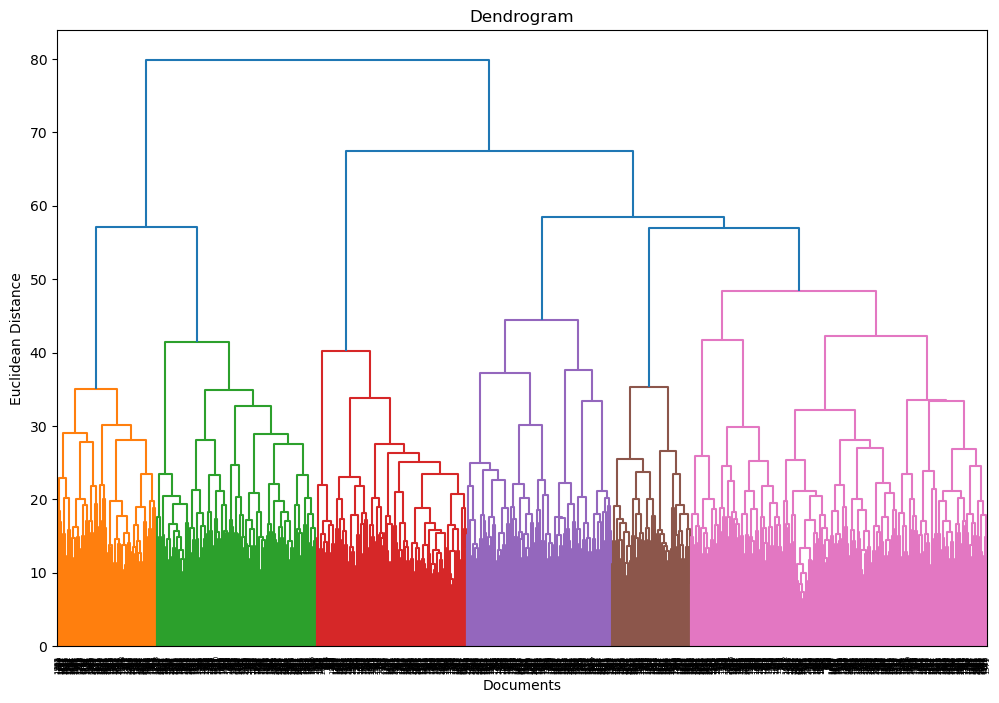

In [13]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

word_vectors = best_model.wv.vectors
cluster_labels_per_linkage = {}
top_keywords_per_linkage = {}  # Store top keywords for each linkage method


hierarchical_clustering = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='complete')

# Fit the model to document vectors
clusters = hierarchical_clustering.fit_predict(document_vectors_pca)

# Add the cluster labels to the DataFrame
df['cluster'] = clusters

# Visualize the dendrogram
plt.figure(figsize=(12, 8))
dendrogram = sch.dendrogram(sch.linkage(document_vectors_pca, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Documents')
plt.ylabel('Euclidean Distance')
plt.show()

## 2.3 Keyword extraction
Selection of the top 15 most frequent words for each cluster based on their similarity to the centroid of that cluster.

In [14]:
# Compute cluster centroids
num_clusters = len(np.unique(clusters))
centroids = []
for cluster_label in range(num_clusters):
    cluster_points = [document_vectors[i] for i, label in enumerate(clusters) if label == cluster_label]
    centroid = np.mean(cluster_points, axis=0)
    centroids.append(centroid / np.linalg.norm(centroid))  # Normalize centroids

# Initialize dictionary to store top keywords per cluster
top_keywords_per_cluster = {}

for cluster_label, centroid in enumerate(centroids):
    # Compute cosine similarity between centroid and all words
    similarities = np.dot(word_vectors, centroid)
    # Get indices of top N words (excluding stopwords or other irrelevant words)
    top_n_indices = np.argsort(similarities)[::-1][:15]  # Top 10 words
    # Get corresponding words from the Word2Vec model's vocabulary
    top_keywords = [best_model.wv.index_to_key[idx] for idx in top_n_indices]
    top_keywords_per_cluster[cluster_label] = top_keywords

# Print top keywords for each cluster
print("Top keywords for the clustering:")
for cluster_label, keywords in top_keywords_per_cluster.items():
    print(f"Cluster {cluster_label}: {', '.join(keywords)}")
print()

Top keywords for the clustering:
Cluster 0: control, monte, carlo, embedded, quantum, system, simulation, planning, hardware, numerical, physic, response, gpu, environment, mobile
Cluster 1: embeddings, contrastive, selfsupervised, graph, semantic, representation, segmentation, label, attention, attribute, pretraining, entity, kg, datasets, pair
Cluster 2: chest, covid, ct, diagnosis, patient, disease, lung, tumor, imaging, auc, cardiac, tomography, cancer, xray, age
Cluster 3: bound, convex, matrix, nonconvex, bandit, column, nonnegative, rank, square, theoretical, convergence, approximation, upper, decomposition, regularization



In [15]:
print(df.head())

                id                                              title  \
245671  2106.10944  [hard, hat, wearing, detection, based, head, k...   
247161  2108.04809  [spiderweb, nanomechanical, resonator, via, ba...   
306836  2307.05506  [datadriven, design, metamaterials, multiscale...   
247853  2109.06365  [heatmaps, structural, explanation, image, cla...   
266701  2204.03761  [quantum, version, knn, classifier, based, qua...   

                               doi                              categories  \
245671  0.24425/bpasts.2023.147340                 cs.CV cs.AI cs.LG cs.NE   
247161      10.1002/adma.202106248  cond-mat.mes-hall cs.LG physics.app-ph   
306836      10.1002/adma.202305254           cs.CE cond-mat.mtrl-sci cs.LG   
247853             10.1002/ail2.46                             cs.CV cs.LG   
266701      10.1002/andp.202100449                          quant-ph cs.LG   

                                                 abstract update_date  \
245671  [recent, ye

In [17]:
%store clusters df

Stored 'clusters' (ndarray)
Stored 'df' (DataFrame)
